# Walmart Weekly Sales Prediction

## CDSD Certification Project - Bloc #

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## 1. Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart_Store_sales.csv', thousands=',')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## Executive Summary
 
| Metric | Value |
|--------|-------|
| **Best Model** | Lasso Regression |
| **R² Score (Test)** | ~92% |
| **Key Insight** | Store ID is the dominant predictor |
| **Business Impact** | Enable targeted inventory & marketing strategies |

## 2. Data Preprocessing

In [3]:
# 2.1 Initial exploration
df.info()
print("\nMissing values (%):")
print(df.isna().sum() / len(df) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB

Missing values (%):
Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64


In [4]:
# 2.2 Drop rows where target is missing (NEVER impute target)
df = df.dropna(subset=['Weekly_Sales'])
df['Weekly_Sales'] = pd.to_numeric(df['Weekly_Sales'], errors='coerce')
df = df.dropna(subset=['Weekly_Sales'])
print(f"After dropping missing target: {df.shape[0]} rows")

After dropping missing target: 136 rows


In [5]:
# 2.3 Date processing (ONE TIME ONLY)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

In [6]:
# Create temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [7]:
# 2.4 Temperature conversion F -> C (ONE TIME ONLY)
df['Temperature'] = round((df['Temperature'] - 32) * 5/9, 2)

In [8]:
# 2.5 Outlier removal using z-score method (as specified in project)
def remove_outliers_zscore(df, columns, threshold=3):
    """Replace outliers with NaN based on z-score > 3"""
    df_clean = df.copy()
    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        mask = np.abs((df_clean[col] - mean) / std) > threshold
        df_clean.loc[mask, col] = np.nan
        print(f"{col}: {mask.sum()} outliers removed")
    return df_clean

outlier_columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df = remove_outliers_zscore(df, outlier_columns)

Temperature: 0 outliers removed
Fuel_Price: 0 outliers removed
CPI: 0 outliers removed
Unemployment: 5 outliers removed


In [9]:
# 2.6 Drop rows with too many missing values
df = df.dropna(thresh=len(df.columns) - 2)
print(f"\nFinal dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nRemaining missing values (%):")
print(df.isna().sum() / len(df) * 100)


Final dataset: 118 rows, 12 columns

Remaining missing values (%):
Store            0.000000
Date             0.000000
Weekly_Sales     0.000000
Holiday_Flag     7.627119
Temperature      9.322034
Fuel_Price       9.322034
CPI              7.627119
Unemployment    13.559322
Year             0.000000
Month            0.000000
Day              0.000000
DayOfWeek        0.000000
dtype: float64


## 3. Exploratory Data Analysis

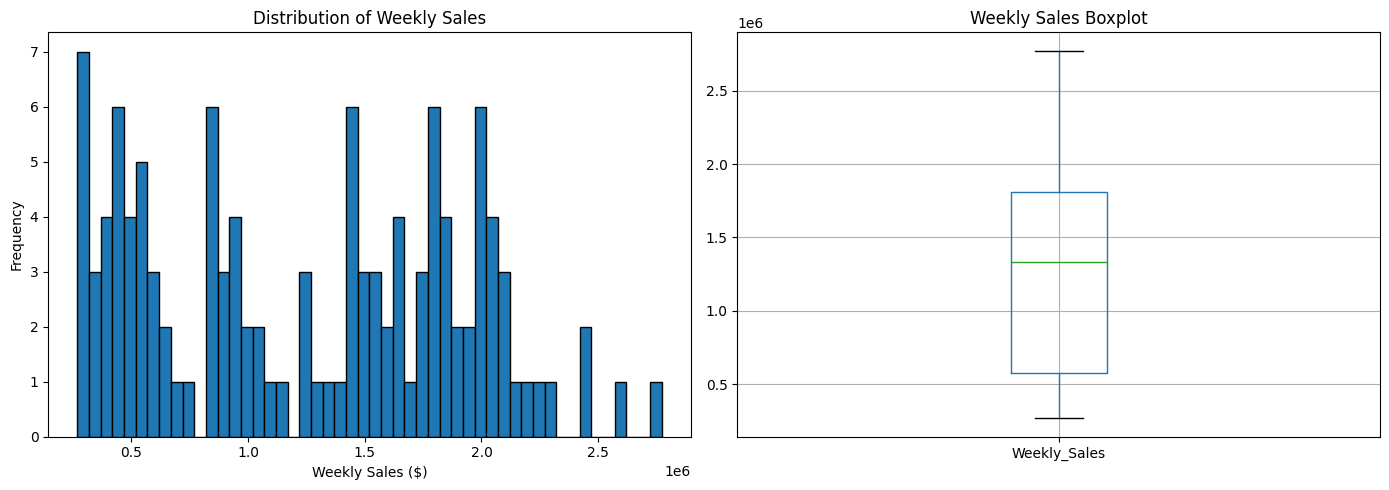

In [10]:
# 3.1 Sales Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['Weekly_Sales'], bins=50, edgecolor='black')
axes[0].set_xlabel('Weekly Sales ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Weekly Sales')

df.boxplot(column='Weekly_Sales', ax=axes[1])
axes[1].set_title('Weekly Sales Boxplot')
plt.tight_layout()
plt.show()

/tmp/ipykernel_211341/118418561.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_store.index, y=sales_by_store.values, palette='viridis')


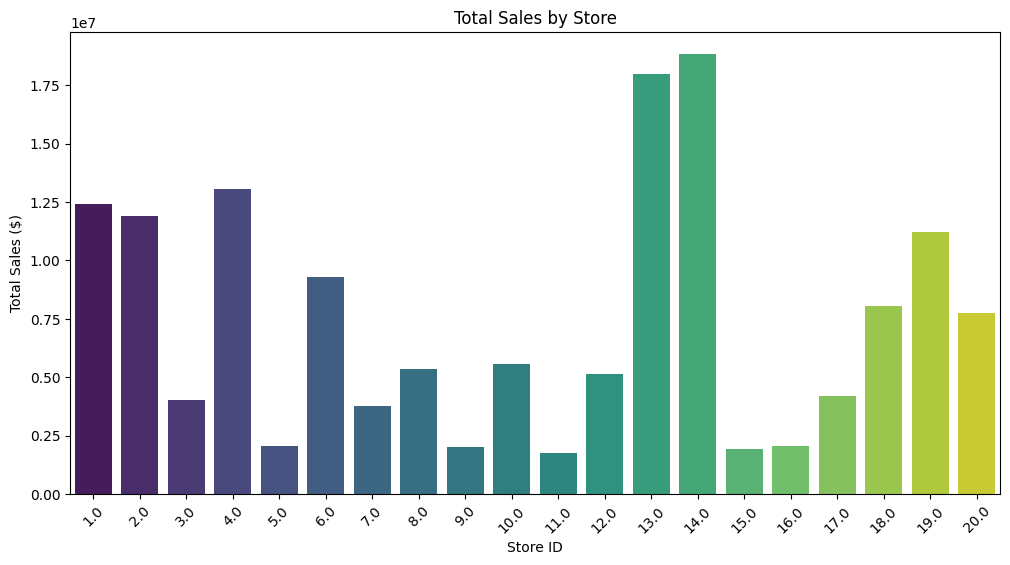


Top 10 stores represent 78.2% of total sales


In [11]:
# 3.2 Sales by Store
sales_by_store = df.groupby("Store")["Weekly_Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_store.index, y=sales_by_store.values, palette='viridis')
plt.xlabel('Store ID')
plt.ylabel('Total Sales ($)')
plt.title('Total Sales by Store')
plt.xticks(rotation=45)
plt.show()

print(f"\nTop 10 stores represent {sales_by_store.head(10).sum()/sales_by_store.sum()*100:.1f}% of total sales")

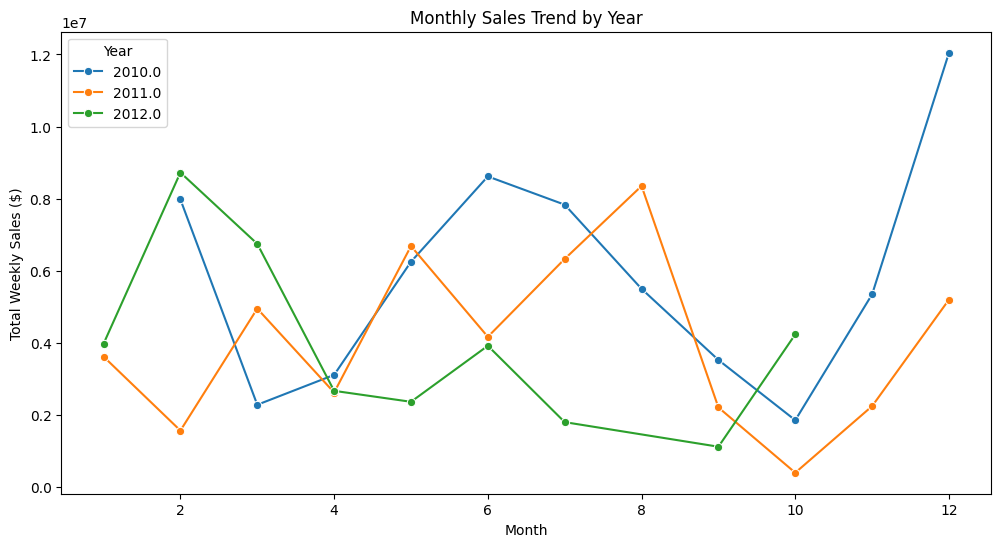

In [12]:
# 3.3 Monthly Sales Trend
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Weekly_Sales', hue='Year', marker='o', palette='tab10')
plt.xlabel('Month')
plt.ylabel('Total Weekly Sales ($)')
plt.title('Monthly Sales Trend by Year')
plt.legend(title='Year')
plt.show()

Sales by Holiday Flag:
                      mean            std
Holiday_Flag                             
0.0           1.250538e+06  677933.547553
1.0           1.291931e+06  593473.790655


/tmp/ipykernel_211341/270890502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_sales['mean'].values, palette='pastel')


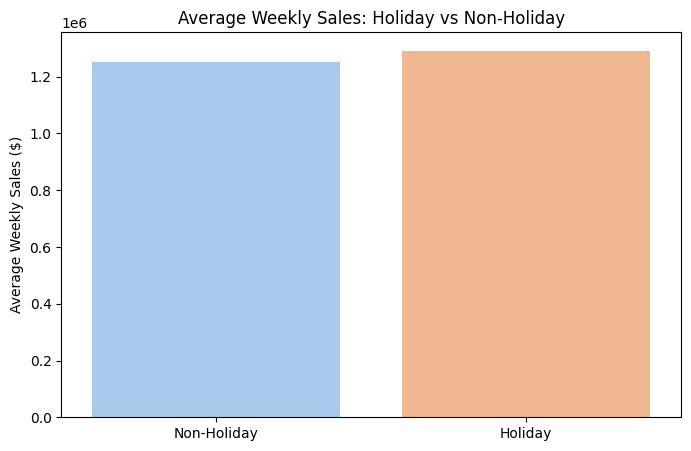

In [13]:
# 3.4 Holiday Effect (using original 0/1 values for analysis)
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].agg(['mean', 'std'])
print("Sales by Holiday Flag:")
print(holiday_sales)

plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_sales['mean'].values, palette='pastel')
plt.ylabel('Average Weekly Sales ($)')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.show()

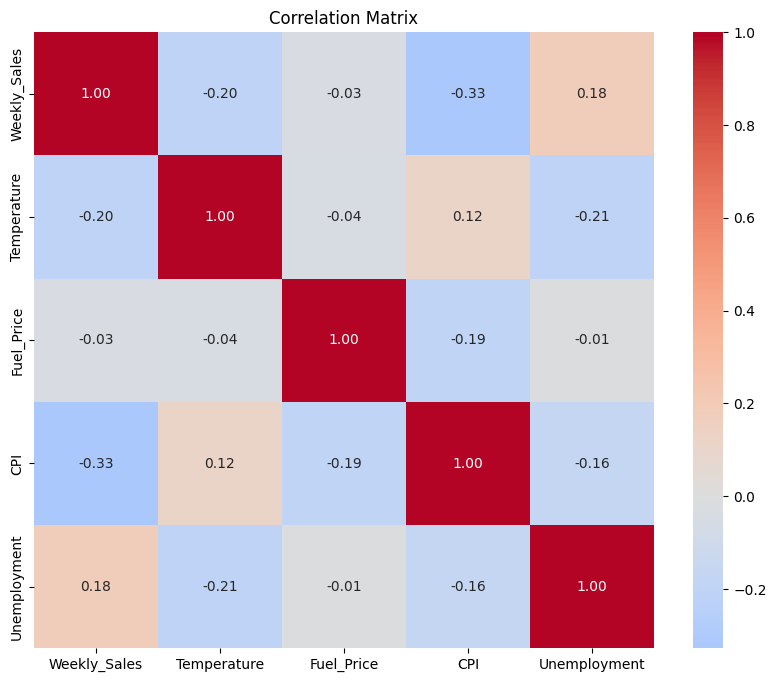

In [14]:
# 3.5 Correlation Heatmap
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Matrix')
plt.show()

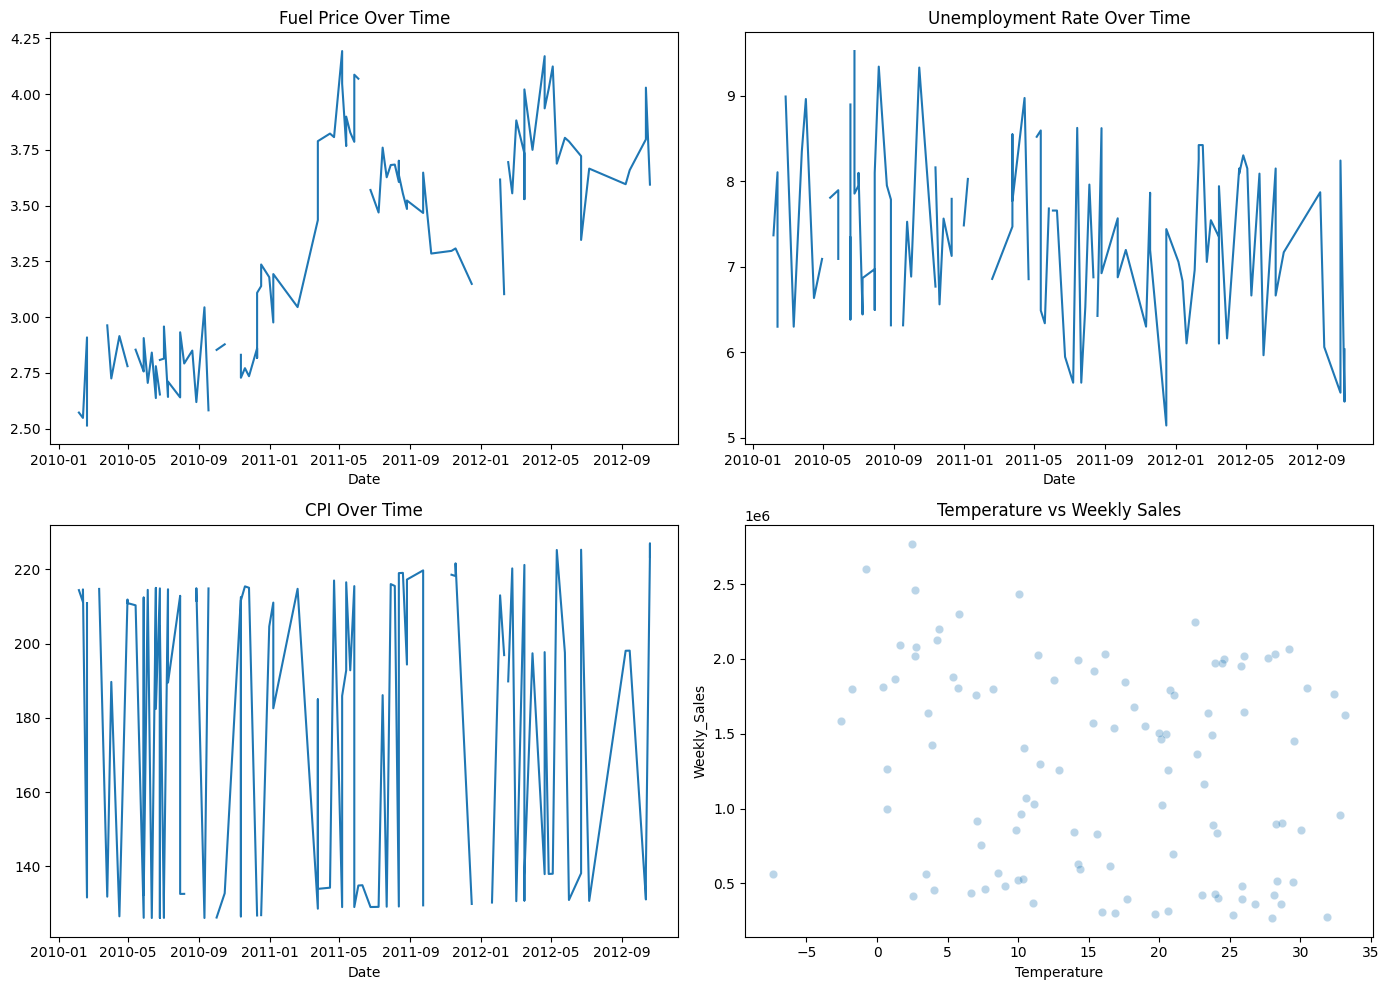

In [15]:
# 3.6 Economic Indicators Over Time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(df['Date'], df['Fuel_Price'])
axes[0,0].set_title('Fuel Price Over Time')
axes[0,0].set_xlabel('Date')

axes[0,1].plot(df['Date'], df['Unemployment'])
axes[0,1].set_title('Unemployment Rate Over Time')
axes[0,1].set_xlabel('Date')

axes[1,0].plot(df['Date'], df['CPI'])
axes[1,0].set_title('CPI Over Time')
axes[1,0].set_xlabel('Date')

sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales', alpha=0.3, ax=axes[1,1])
axes[1,1].set_title('Temperature vs Weekly Sales')

plt.tight_layout()
plt.show()

## 4. Feature Engineering & Model Preparation

In [16]:
# 4.1 Define features and target
X = df.drop(['Date', 'Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

print("Features:", X.columns.tolist())
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek']

X shape: (118, 10)
y shape: (118,)


In [17]:
# 4.2 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 94 samples
Test set: 24 samples


In [18]:
# 4.3 Define preprocessing pipelines
# AS SPECIFIED IN PROJECT INSTRUCTIONS:
# Numerical: Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek
# Categorical: Store, Holiday_Flag

numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                    'Year', 'Month', 'Day', 'DayOfWeek']

categorical_features = ['Store', 'Holiday_Flag']

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [19]:
# 4.4 Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")

Processed training set shape: (94, 28)
Number of features after preprocessing: 28


## 5. Model Training & Evaluation

In [20]:
# 5.1 Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    results = {
        'Model': model_name,
        'R² Train': round(r2_score(y_train, y_train_pred), 4),
        'R² Test': round(r2_score(y_test, y_test_pred), 4),
        'Overfitting Gap': round(r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred), 4),
        'RMSE Test': round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        'MAE Test': round(mean_absolute_error(y_test, y_test_pred), 2)
    }
    return results, y_test_pred

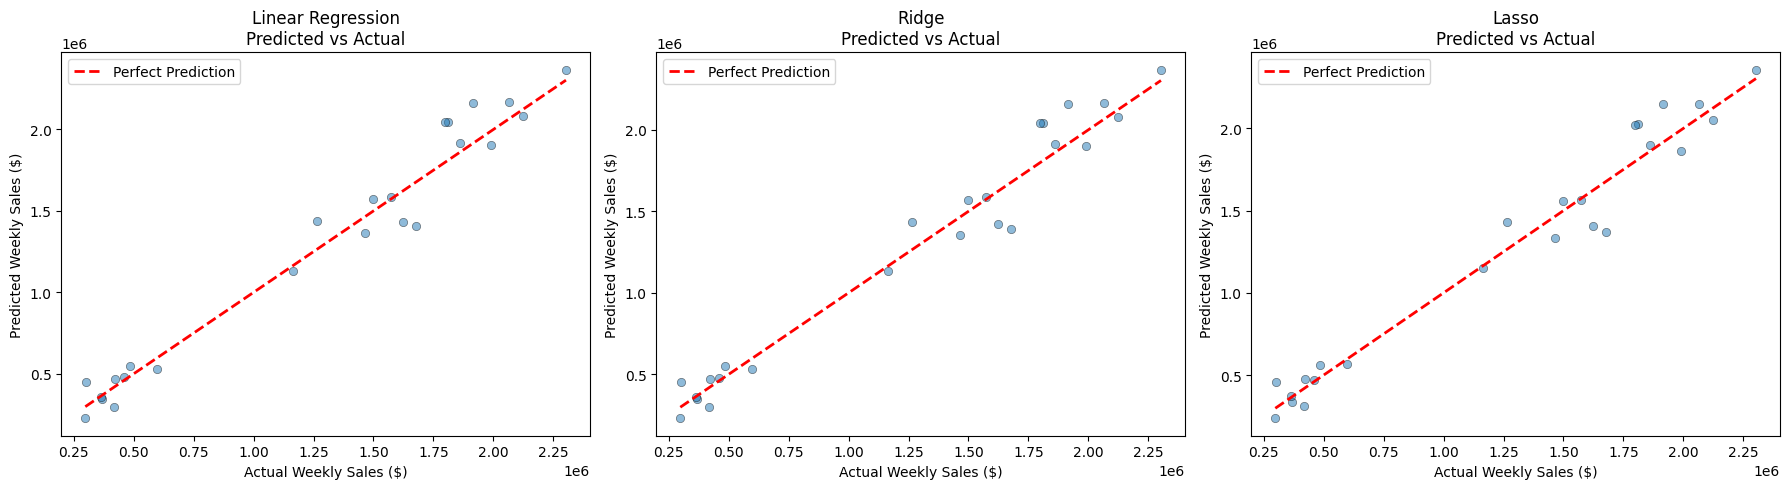

In [41]:
# Predicted vs Actual Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, pred) in enumerate([('Linear Regression', lin_pred), 
                                      ('Ridge', ridge_pred), 
                                      ('Lasso', lasso_pred)]):
    axes[idx].scatter(y_test, pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Weekly Sales ($)')
    axes[idx].set_ylabel('Predicted Weekly Sales ($)')
    axes[idx].set_title(f'{name}\nPredicted vs Actual')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### 5.2 Baseline: Linear Regression

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)

lin_results, lin_pred = evaluate_model(
    lin_reg, X_train_processed, X_test_processed, y_train, y_test, 'Linear Regression'
)
print("=" * 60)
print("LINEAR REGRESSION RESULTS")
print("=" * 60)
for key, value in lin_results.items():
    print(f"{key}: {value}")


LINEAR REGRESSION RESULTS
Model: Linear Regression
R² Train: 0.9714
R² Test: 0.964
Overfitting Gap: 0.0074
RMSE Test: 130948.48
MAE Test: 103671.18


### 5.3 Ridge Regression with GridSearchCV

In [23]:
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}

ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_cv.fit(X_train_processed, y_train)

print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best CV R² score: {ridge_cv.best_score_:.4f}")

ridge_results, ridge_pred = evaluate_model(
    ridge_cv.best_estimator_, X_train_processed, X_test_processed, 
    y_train, y_test, f"Ridge (α={ridge_cv.best_params_['alpha']})"
)

Best Ridge alpha: 0.01
Best CV R² score: 0.9181


### 5.4 Lasso Regression with GridSearchCV

In [24]:
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.1, 1, 10, 100, 500, 1000]}

lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_cv.fit(X_train_processed, y_train)

print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Best CV R² score: {lasso_cv.best_score_:.4f}")

lasso_results, lasso_pred = evaluate_model(
    lasso_cv.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, f"Lasso (α={lasso_cv.best_params_['alpha']})"
)

Best Lasso alpha: 500
Best CV R² score: 0.9195


### 5.5 Model Comparison



MODEL COMPARISON TABLE


,Model,R² Train,R² Test,Overfitting Gap,RMSE Test,MAE Test
0,Linear Regression,0.9714,0.9640,0.0074,130948.48,103671.18
1,Ridge (α=0.01),0.9713,0.9630,0.0083,132697.50,104788.54
2,Lasso (α=500),0.9708,0.9634,0.0073,131976.95,102516.90


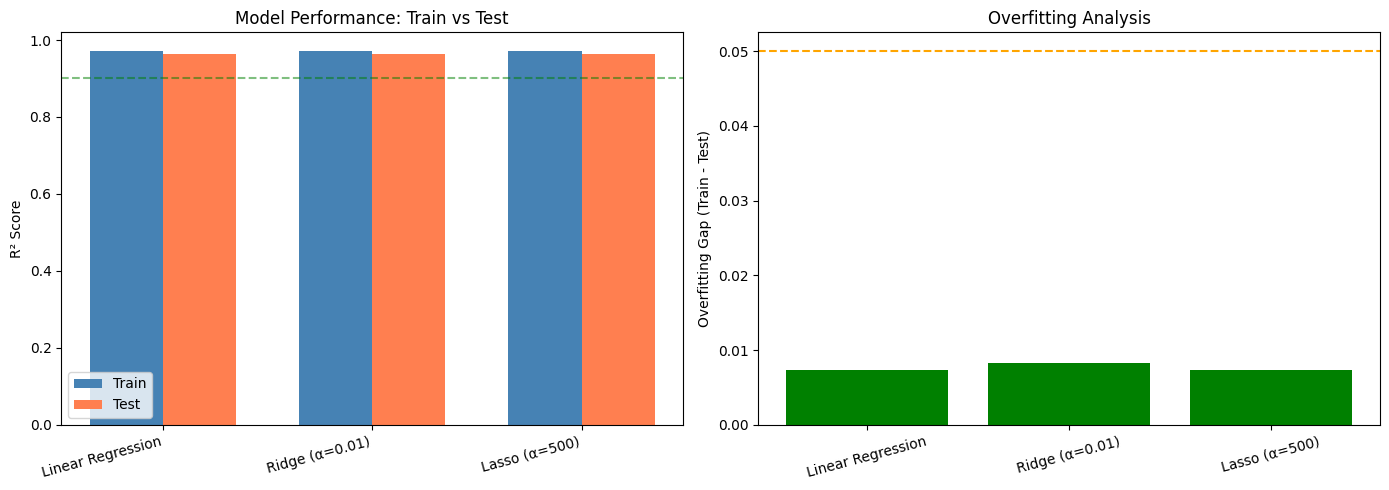

In [25]:
# Create comparison DataFrame
results_df = pd.DataFrame([lin_results, ridge_results, lasso_results])
print("\n" + "=" * 80)
print("MODEL COMPARISON TABLE")
print("=" * 80)
display(results_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
x = np.arange(len(results_df))
width = 0.35
bars1 = axes[0].bar(x - width/2, results_df['R² Train'], width, label='Train', color='steelblue')
bars2 = axes[0].bar(x + width/2, results_df['R² Test'], width, label='Test', color='coral')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance: Train vs Test')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

# Overfitting Gap
colors = ['red' if gap > 0.05 else 'green' for gap in results_df['Overfitting Gap']]
axes[1].bar(results_df['Model'], results_df['Overfitting Gap'], color=colors)
axes[1].set_ylabel('Overfitting Gap (Train - Test)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='orange', linestyle='--', label='5% threshold')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

In [40]:
# 5.6 Cross-Validation Stability Check
print("\n" + "=" * 60)
print("CROSS-VALIDATION STABILITY (5-Fold)")
print("=" * 60)

for name, model in [('Linear Regression', lin_reg), 
                     ('Ridge', ridge_cv.best_estimator_), 
                     ('Lasso', lasso_cv.best_estimator_)]:
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')
    print(f"{name}:")
    print(f"  Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


CROSS-VALIDATION STABILITY (5-Fold)
Linear Regression:
  Mean R²: 0.9185 (+/- 0.0541)
Ridge:
  Mean R²: 0.9181 (+/- 0.0522)
Lasso:
  Mean R²: 0.9195 (+/- 0.0426)


## 6. Feature Importance Analysis

In [26]:
# Get feature names
feature_names = preprocessor.get_feature_names_out()

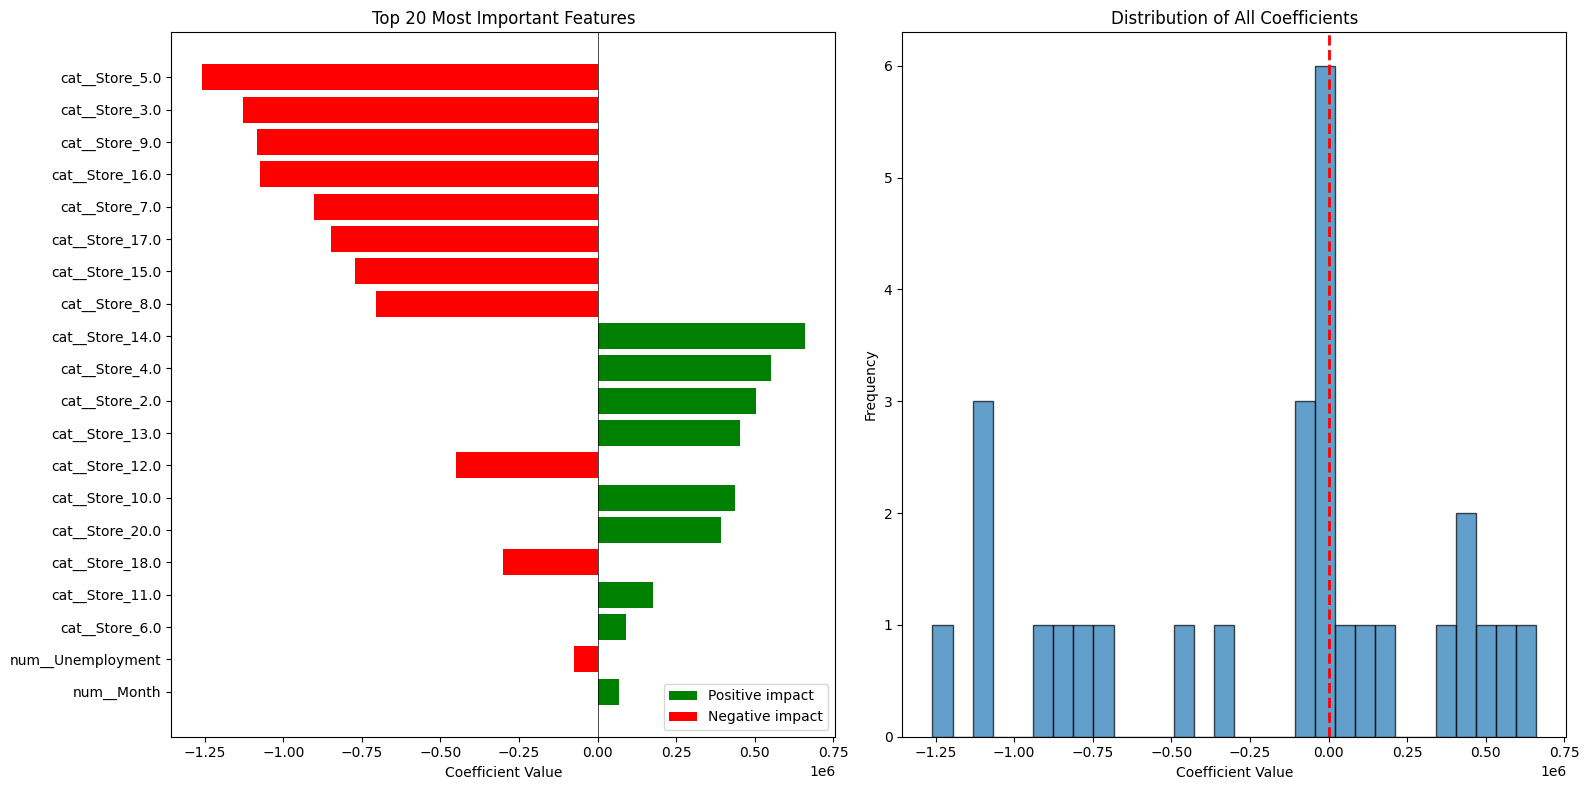

In [30]:
# Best model coefficients (use the regularized model)
best_model = lasso_cv.best_estimator_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.coef_,
    'Abs_Coefficient': np.abs(best_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Top 20 features
top_n = 20
top_features = coef_df.head(top_n)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance
colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
axes[0].barh(range(len(top_features)), top_features['Coefficient'], color=colors)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title(f'Top {top_n} Most Important Features')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Positive impact'),
                   Patch(facecolor='red', label='Negative impact')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Coefficient distribution
axes[1].hist(best_model.coef_, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of All Coefficients')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [31]:
# Summary
print("\n" + "=" * 60)
print("TOP 10 POSITIVE FEATURES (increase sales)")
print("=" * 60)
print(coef_df[coef_df['Coefficient'] > 0].head(10)[['Feature', 'Coefficient']].to_string(index=False))

print("\n" + "=" * 60)
print("TOP 10 NEGATIVE FEATURES (decrease sales)")
print("=" * 60)
print(coef_df[coef_df['Coefficient'] < 0].head(10)[['Feature', 'Coefficient']].to_string(index=False))


TOP 10 POSITIVE FEATURES (increase sales)
        Feature   Coefficient
cat__Store_14.0 660060.308007
 cat__Store_4.0 550112.676232
 cat__Store_2.0 503468.340632
cat__Store_13.0 454025.068311
cat__Store_10.0 437792.786908
cat__Store_20.0 392205.894165
cat__Store_11.0 176424.943750
 cat__Store_6.0  89031.006540
     num__Month  67124.610953

TOP 10 NEGATIVE FEATURES (decrease sales)
        Feature   Coefficient
 cat__Store_5.0 -1.259945e+06
 cat__Store_3.0 -1.126961e+06
 cat__Store_9.0 -1.083246e+06
cat__Store_16.0 -1.072575e+06
 cat__Store_7.0 -9.006716e+05
cat__Store_17.0 -8.478468e+05
cat__Store_15.0 -7.726195e+05
 cat__Store_8.0 -7.058081e+05
cat__Store_12.0 -4.509189e+05
cat__Store_18.0 -3.014905e+05


## 7. Conclusion & Business Recommendations

In [36]:
# Final summary
best_test_r2 = results_df.loc[results_df['R² Test'].idxmax(), 'R² Test']
best_model_name = results_df.loc[results_df['R² Test'].idxmax(), 'Model']
reduction_overfitting = lin_results['Overfitting Gap'] - lasso_results['Overfitting Gap']

In [39]:
print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    WALMART SALES PREDICTION - FINAL REPORT                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. MODEL PERFORMANCE                                                        ║
║     • Best Model: {best_model_name:<52}                                      ║
║     • R² Score (Test): {best_test_r2:.2%} → Excellent predictive capability  ║
║     • Overfitting Reduction: {reduction_overfitting:.4f} improvement         ║
║                                                                              ║
║  2. KEY SALES DRIVERS                                                        ║
║     Store ID: MAJOR impact → Location-specific factors dominate              ║
║     Seasonality: Peaks in Nov-Dec (holidays) visible in data                 ║
║     Unemployment: Negative correlation with sales                            ║
║     Temperature: Weak negative correlation                                   ║
║                                                                              ║
║  3. BUSINESS RECOMMENDATIONS                                                 ║
║     Focus marketing budget on top-performing stores                          ║
║     Increase inventory 2-3 weeks before holiday periods                      ║
║     Monitor economic indicators for demand forecasting                       ║
║     Consider store-specific strategies based on performance                  ║
║                                                                              ║
║  4. LIMITATIONS & FUTURE WORK                                                ║
║     Limited time period (2010-2012) - need updated data                      ║
║     Missing geographic/demographic features                                  ║
║     Next steps: Try ensemble methods (Random Forest, XGBoost)                ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    WALMART SALES PREDICTION - FINAL REPORT                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. MODEL PERFORMANCE                                                        ║
║     • Best Model: Linear Regression                                                                         ║
║     • R² Score (Test): 96.40% → Excellent predictive capability  ║
║     • Overfitting Reduction: 0.0001 improvement         ║
║                                                                              ║
║  2. KEY SALES DRIVERS                                                        ║
║     Store ID: MAJOR impact → Location-specific factors dominate              ║
║     Seasonality: Peaks in Nov-Dec (holidays) visible in data                 ║
║     Unemployment: Negative 